<h1 style="text-align: center;text-decoration: underline;">Pré-soutenance:</h1>
<h2 style="text-align: center;">Etude des prix et des caracteristiques des laptops</h2>

### Chargement des bibliothéques ...

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #visualisation
import seaborn as sns #visualisation
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import json

### Chargement des données ...


In [47]:
laptop = pd.read_csv("data/price.csv",encoding = "ISO-8859-1")

### Receuillir quelques informations sur le dataframe

In [48]:
print("dimension du dataframe:\nlignes:",laptop.shape[0],"\ncolonnes:",laptop.shape[1])
display("\n\ninformation sur le dataframe:")
laptop.info()

dimension du dataframe:
lignes: 1303 
colonnes: 13


'\n\ninformation sur le dataframe:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


### Vérification des données manquantes ...

In [49]:
laptop.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

### Vérification des données dupliquées ...

In [50]:
# Utilisation de la méthode duplicated() avec keep=False pour trouver les lignes parfaitement dupliquées
duplicatas = laptop.duplicated(keep=False)
nombre_duplicatas = laptop[duplicatas].shape[0]
# nombre de lignes parfaitement dupliquées
display("Nombre de lignes parfaitement dupliquées :", nombre_duplicatas)

'Nombre de lignes parfaitement dupliquées :'

0

### On remarque que la base de données de notre choix ne comporte aucune valeur manquante, ni de ligne dupliquée! 

### En regardant la premiere colonne du dataframe on s'apercoit que l ID n'est juste que le numero de la ligne dans ce cas cette colonne est redondante et supprimable

In [51]:
laptop.drop("laptop_ID", axis=1, inplace=True)
#vue sur le nouveau dataframe
display(laptop.head(5))

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


#### Les valeurs uniques

In [52]:
laptop.apply(lambda x: len(x.unique()))

Company              19
Product             618
TypeName              6
Inches               18
ScreenResolution     40
Cpu                 118
Ram                   9
Memory               39
Gpu                 110
OpSys                 9
Weight              179
Price_euros         791
dtype: int64

#### Type des variables de laptop

In [53]:
laptop.dtypes

Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object

#### Maintenant je vais détailler le dataframe dans un nouveau dataframe plus explicite et facile a manier

In [54]:
pc=laptop[["Company","TypeName","Inches","Price_euros"]].copy()

#### Maintenant j'éclate ou formate les cases des colonnes restantes

##### Retrait des parentheses redondantes dans produit contenant des lignes d'inforrmations contenues dans les autres cases 

In [55]:
#produit
pc["Produit"] = laptop["Product"].apply(lambda x: x.split("(")[0] if "(" in x else x)


In [56]:
def memoire(x):
    if("SSD" in laptop["Memory"]):
        if("GB" in laptop["Memory"].str.split("SSD")[0]):
            mem0=laptop["Memory"].str.split("SSD")[0]
            pc["SSD"]=laptop["Memory"].str.extract(r"(\d+)GB SSD").astype(float)
        else:
            pc["SSD_GB"] = laptop["Memory"].str.extract(r"(\d+)TB SSD").astype(float)*1000

        if("GB" in laptop["Memory"].str.split("SSD")[1]):
            pc["SSD"]=laptop["Memory"].str.extract(r"(\d+)GB SSD").astype(float)
        else:
            pc["SSD_GB"] = laptop["Memory"].str.extract(r"(\d+)TB SSD").astype(float)*1000

In [57]:
#info generale
pc["os"]=laptop["OpSys"]
pc["Poids"]=laptop["Weight"].str.replace('kg',"")
pc["Poids"]=pd.to_numeric(pc["Poids"])

In [58]:
#ram
pc["Ram"]=laptop["Ram"].str.replace("GB","")
pc["Ram"]=pd.to_numeric(pc["Ram"])

In [59]:
#ecran
pc['Tactile']=laptop['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
pc['Dalle_ips']=laptop['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

In [60]:
#carte graphique
pc["gpu_compagnie"] = laptop["Gpu"].str.split(n=1).str[0]
pc["gpu_modele"] = laptop["Gpu"].str.split(n=1).str[1]

In [61]:
#memoire
laptop['SSD'] = 0
laptop['HDD'] = 0

def extract_ssd_gb(memory_string):
    ssd_gb = 0
    if "SSD" in memory_string:
        ssd_entry = memory_string.split('+')[0]  
        if "TB" in ssd_entry:
            ssd_tb = float(ssd_entry.split("TB")[0])
            ssd_gb += ssd_tb * 1000
        elif "GB" in ssd_entry:
            ssd_gb += float(ssd_entry.split("GB")[0])
    return ssd_gb

def extract_hdd_gb(memory_string):
    hdd_gb = 0
    if "HDD" in memory_string:
        hdd_entry = memory_string.split('+')[-1] 
        if "TB" in hdd_entry:
            hdd_tb = float(hdd_entry.split("TB")[0])
            hdd_gb += hdd_tb * 1000
        elif "GB" in hdd_entry:
            hdd_gb += float(hdd_entry.split("GB")[0])
    return hdd_gb

def extract_flash_gb(memory_string):
    flash_gb = 0
    if "Flash Storage" in memory_string:
        flash_entry = memory_string.split('Flash Storage')[0]
        if "TB" in flash_entry:
            flash_tb = float(flash_entry.split("TB")[0])
            flash_gb += flash_tb * 1000
        elif "GB" in flash_entry:
            flash_gb += float(flash_entry.split("GB")[0])
    return flash_gb

pc['SSD'] = laptop['Memory'].apply(extract_ssd_gb)
pc['HDD'] = laptop['Memory'].apply(extract_hdd_gb)
pc['Flash_Storage'] = laptop['Memory'].apply(extract_flash_gb)

In [62]:
#resolution
pc['ResX'] = laptop['ScreenResolution'].str.extract(r'(\d+)x\d+')
pc['ResY'] = laptop['ScreenResolution'].str.extract(r'\d+x(\d+)')
pc['ResX'] = pd.to_numeric(pc['ResX'])
pc['ResY'] = pd.to_numeric(pc['ResY'])

In [63]:
pc["gpu_compagnie"].value_counts().sort_values(ascending=False)

gpu_compagnie
Intel     722
Nvidia    400
AMD       180
ARM         1
Name: count, dtype: int64

### Nous remarquons que ARM est un outlier il est unique dans tout le tableau marginalement aux autres  il n'a pas d importance !

In [64]:
pc= pc[pc["gpu_compagnie"] != 'ARM']
display(len(pc["gpu_compagnie"]))
print(pc["gpu_compagnie"].value_counts().sort_values(ascending=False))


1302

gpu_compagnie
Intel     722
Nvidia    400
AMD       180
Name: count, dtype: int64


In [65]:
def os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    if inp=='No OS':
        return 'No Os'
    if inp=='Linux':
        return 'Linux'
    if inp=='Chrome OS':
        return 'Chrome OS'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Android'

In [66]:
#os
pc['os'] = laptop['OpSys'].apply(os)

In [67]:
def extract_model(cpu_string):
    parts = cpu_string.split(" ", 1)
    if len(parts) > 1:
        return parts[1].rsplit(" ", 1)[0]
    else:
        return ""

In [68]:
#processeur
pc["proc_compagnie"]=laptop["Cpu"].str.split(n=-1).str[0]
pc["proc_frequence"] = laptop["Cpu"].str.split(n=-1).str[-1]
pc["proc_frequence"] = pc["proc_frequence"].str.replace("GHz", "")
pc["proc_frequence"] = pd.to_numeric(pc["proc_frequence"])
pc["proc_modele"] = laptop["Cpu"].apply(extract_model)




In [69]:
display(pc.head(5))

,Company,TypeName,Inches,Price_euros,Produit,os,Poids,Ram,Tactile,Dalle_ips,gpu_compagnie,gpu_modele,SSD,HDD,Flash_Storage,ResX,ResY,proc_compagnie,proc_frequence,proc_modele
0,Apple,Ultrabook,13.3,1339.69,MacBook Pro,Mac,1.37,8,0,1,Intel,Iris Plus Graphics 640,128.0,0.0,0.0,2560,1600,Intel,2.3,Core i5
1,Apple,Ultrabook,13.3,898.94,Macbook Air,Mac,1.34,8,0,0,Intel,HD Graphics 6000,0.0,0.0,128.0,1440,900,Intel,1.8,Core i5
2,HP,Notebook,15.6,575.00,250 G6,No Os,1.86,8,0,0,Intel,HD Graphics 620,256.0,0.0,0.0,1920,1080,Intel,2.5,Core i5 7200U
3,Apple,Ultrabook,15.4,2537.45,MacBook Pro,Mac,1.83,16,0,1,AMD,Radeon Pro 455,512.0,0.0,0.0,2880,1800,Intel,2.7,Core i7
4,Apple,Ultrabook,13.3,1803.60,MacBook Pro,Mac,1.37,8,0,1,Intel,Iris Plus Graphics 650,256.0,0.0,0.0,2560,1600,Intel,3.1,Core i5


### Maintenant le tableau est nettoyé, propre, sans duplicata et plus détaillé 

In [70]:
print("\ninformation sur le dataframe:")
pc.info()
pc.apply(lambda x: len(x.unique()))



information sur le dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company         1302 non-null   object 
 1   TypeName        1302 non-null   object 
 2   Inches          1302 non-null   float64
 3   Price_euros     1302 non-null   float64
 4   Produit         1302 non-null   object 
 5   os              1302 non-null   object 
 6   Poids           1302 non-null   float64
 7   Ram             1302 non-null   int64  
 8   Tactile         1302 non-null   int64  
 9   Dalle_ips       1302 non-null   int64  
 10  gpu_compagnie   1302 non-null   object 
 11  gpu_modele      1302 non-null   object 
 12  SSD             1302 non-null   float64
 13  HDD             1302 non-null   float64
 14  Flash_Storage   1302 non-null   float64
 15  ResX            1302 non-null   int64  
 16  ResY            1302 non-null   int64  
 17  proc_co

Company            19
TypeName            6
Inches             18
Price_euros       791
Produit           592
os                  6
Poids             171
Ram                 9
Tactile             2
Dalle_ips           2
gpu_compagnie       3
gpu_modele        109
SSD                11
HDD                 6
Flash_Storage       7
ResX               13
ResY               10
proc_compagnie      2
proc_frequence     25
proc_modele        92
dtype: int64

### Maintenant analysons le dataframe pour voir les tendances, les correlations, les groupes

regardons la popularité des marques et modeles sur les ordinateurs

In [71]:
#retrait de Resy due a la corelation parfaite avec resx
pc_analyse = pc[["Inches", "ResX","Ram","Poids","proc_frequence","SSD","HDD","Flash_Storage","os","Company","Tactile","Dalle_ips","proc_compagnie","proc_modele","TypeName","Price_euros"]].copy()

# List of column names with object data type that you want to convert to numeric
columns_to_convert = ["os","Company","proc_compagnie","proc_modele","TypeName"]

# Convert the specified columns to numeric
for col in columns_to_convert:
    pc_analyse[col] = pd.factorize(pc_analyse[col])[0]


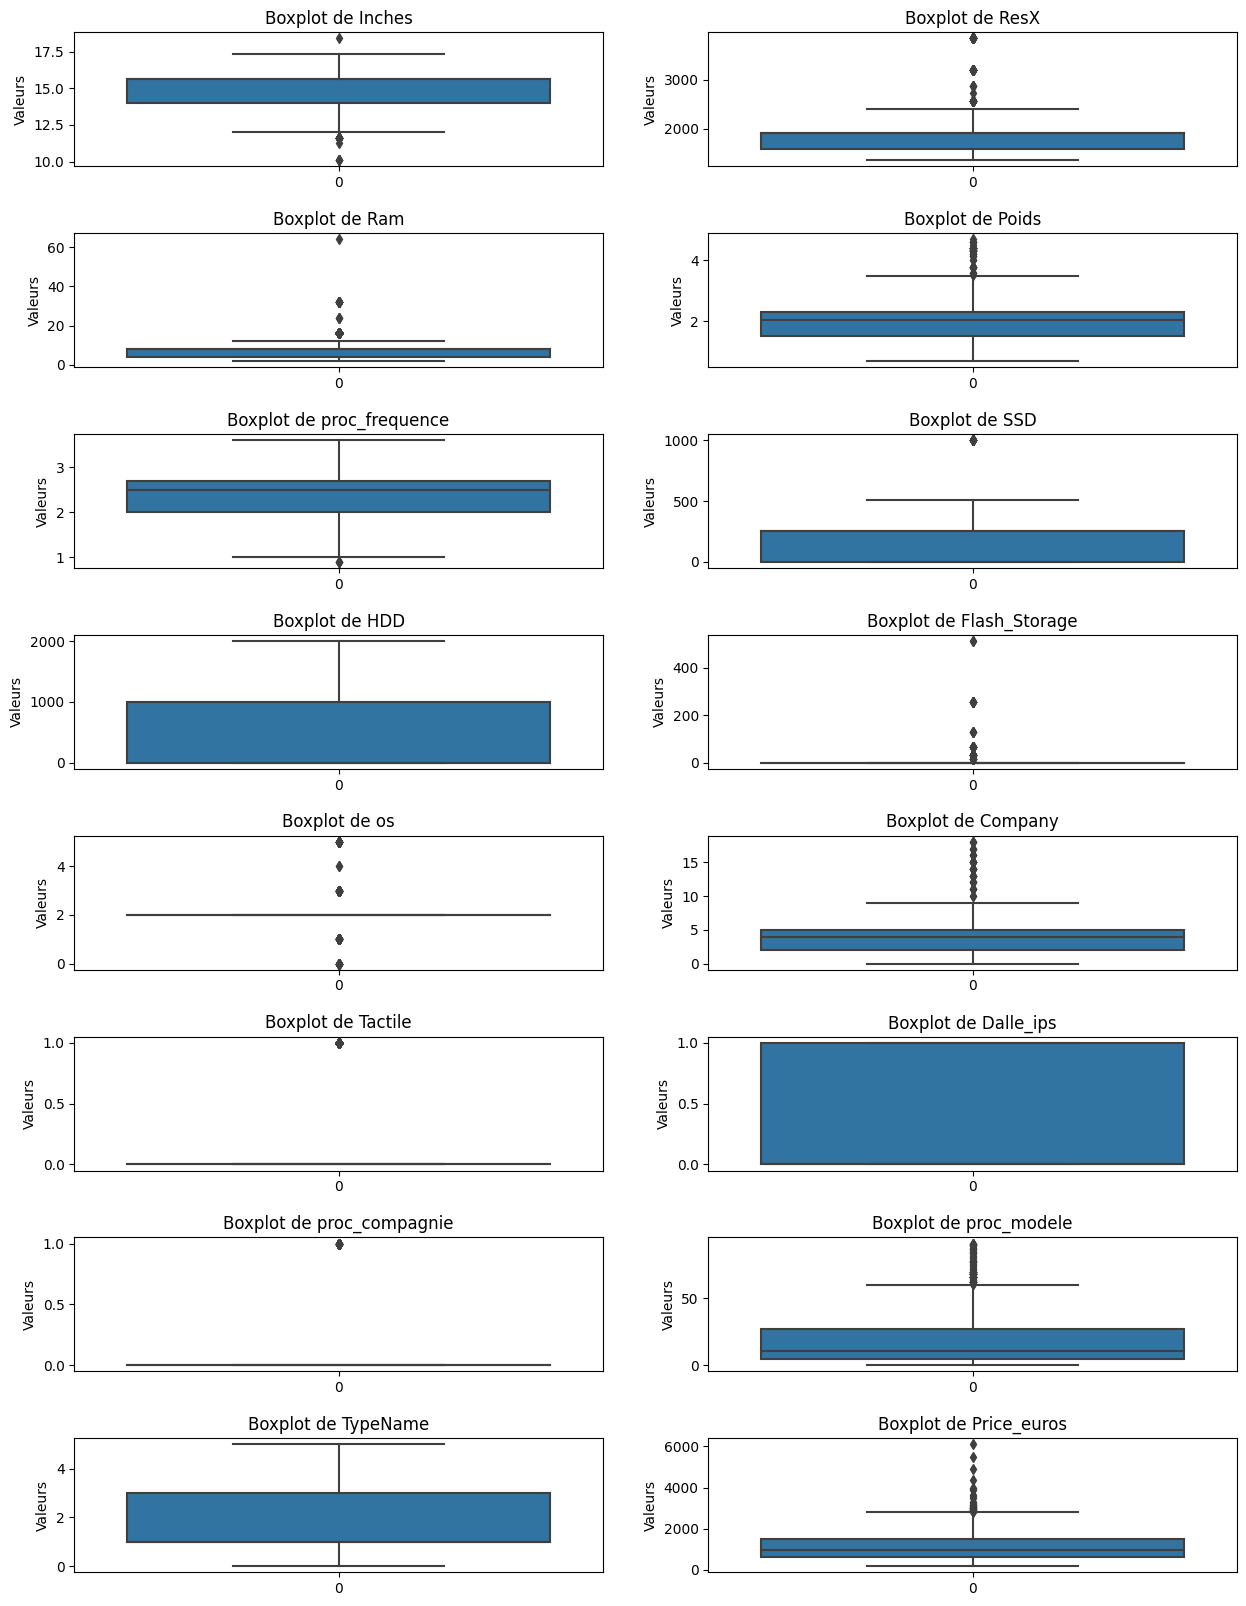

In [72]:
# Liste des noms de colonnes numériques que vous voulez tracer
numeric_columns = pc_analyse.columns

# Calculer le nombre de lignes et de colonnes pour la matrice
num_rows = len(numeric_columns) // 2 + len(numeric_columns) % 2
num_cols = 2

# Créer la matrice de sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# Tracer les boxplots pour chaque colonne numérique
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(data=pc_analyse[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot de {column}')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Valeurs')

# Supprimer les sous-graphiques vides si nécessaire
if len(numeric_columns) % 2 != 0:
    axes[num_rows - 1, 1].axis('off')

# Afficher les sous-graphiques
plt.show()

### Etude des relations

<Axes: xlabel='gpu_compagnie'>

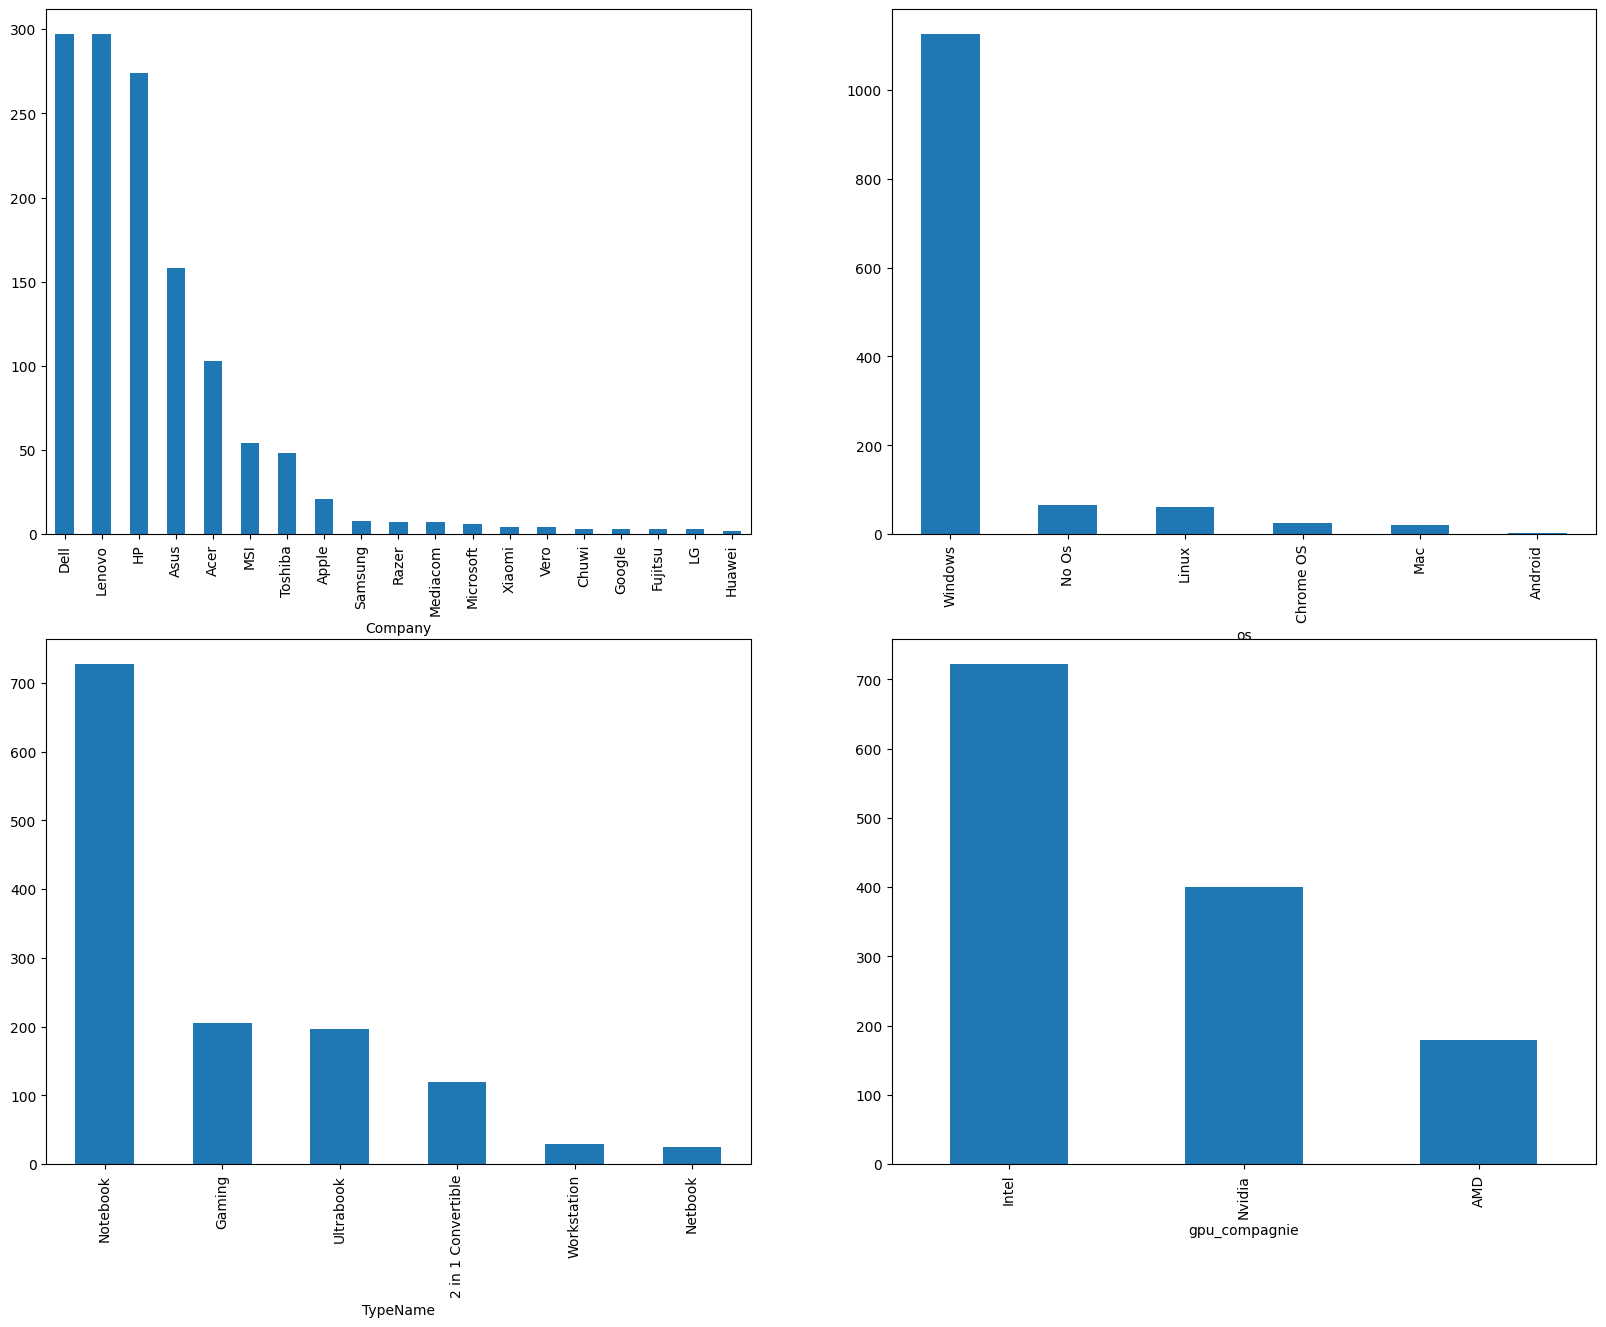

In [73]:
plt.figure(figsize=(20,15))   #try

plt.subplot(2,2,1)
pc['Company'].value_counts().plot(kind='bar')

plt.subplot(2,2,2)
pc['os'].value_counts().plot(kind='bar')

plt.subplot(2,2,3)
pc['TypeName'].value_counts().plot(kind='bar')

plt.subplot(2,2,4)
pc['gpu_compagnie'].value_counts().plot(kind='bar')

la taille des écrans

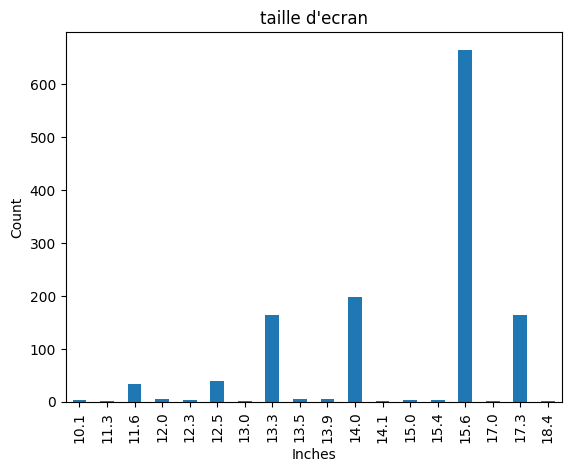

In [74]:
sorted_value_counts = pc['Inches'].value_counts().sort_index()
 
sorted_value_counts.plot(kind='bar')

plt.xlabel('Inches')
plt.ylabel('Count')
plt.title('taille d\'ecran')

plt.show()

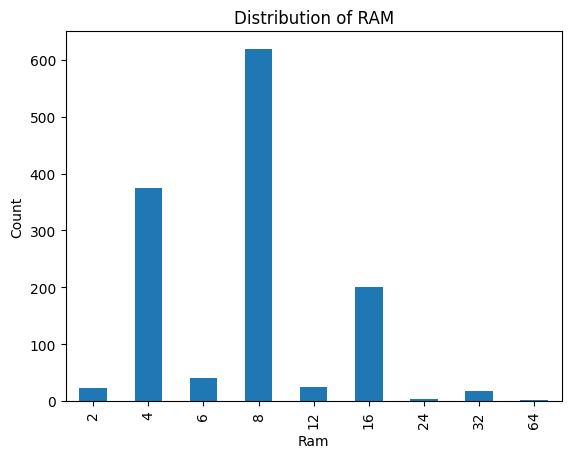

In [75]:
sorted_ram_value_counts = pc['Ram'].value_counts().sort_index()

# Create the bar plot with the sorted value counts
sorted_ram_value_counts.plot(kind='bar')

plt.title('Distribution of RAM')
plt.xlabel('Ram')
plt.ylabel('Count')

plt.show()

<Axes: xlabel='Price_euros', ylabel='Count'>

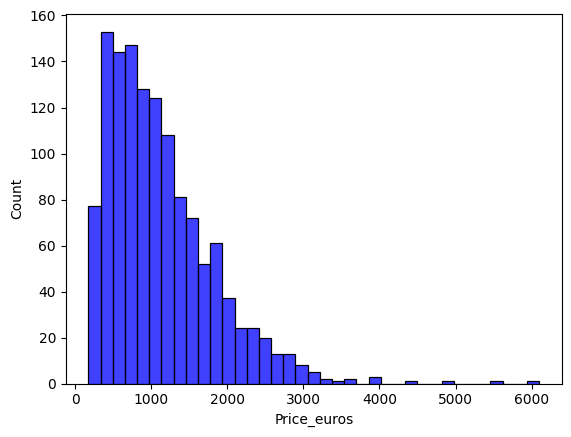

In [76]:
sns.histplot(laptop['Price_euros'],color='blue')

<Axes: xlabel='proc_compagnie'>

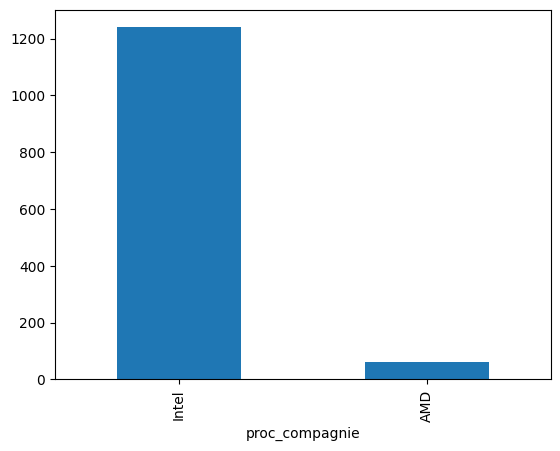

In [77]:
pc['proc_compagnie'].value_counts().plot(kind='bar')

<Axes: xlabel='Flash_Storage'>

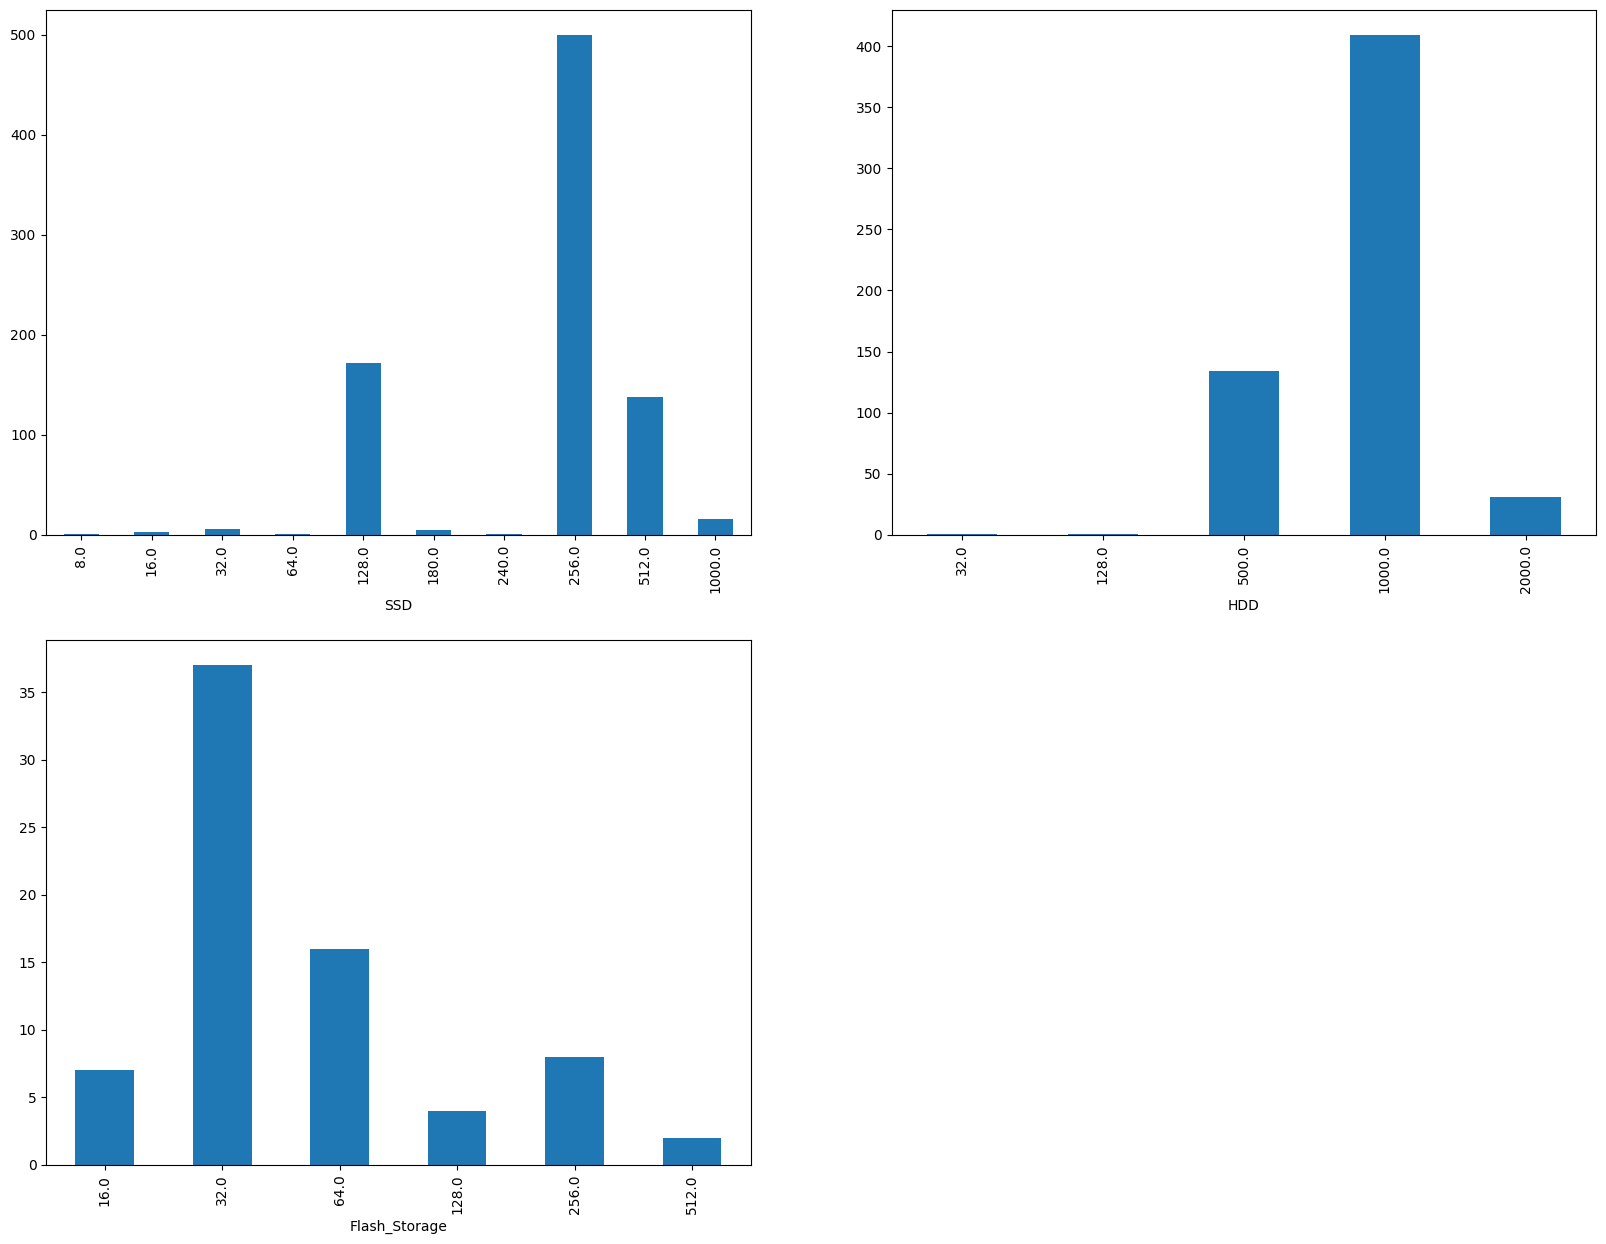

In [78]:
plt.figure(figsize=(20,15))   #try

plt.subplot(2,2,1)
SSD_filtered = pc[pc['SSD'] != 0]
SSD_counts = SSD_filtered['SSD'].value_counts().sort_index()
SSD_counts.plot(kind='bar')


plt.subplot(2,2,2)
HDD_filtered = pc[pc['HDD'] != 0]
HDD_counts = HDD_filtered['HDD'].value_counts().sort_index()
HDD_counts.plot(kind='bar')

plt.subplot(2,2,3)
FS_filtered = pc[pc['Flash_Storage'] != 0]
FS_counts = FS_filtered['Flash_Storage'].value_counts().sort_index()
FS_counts.plot(kind='bar')

<Axes: xlabel='os'>

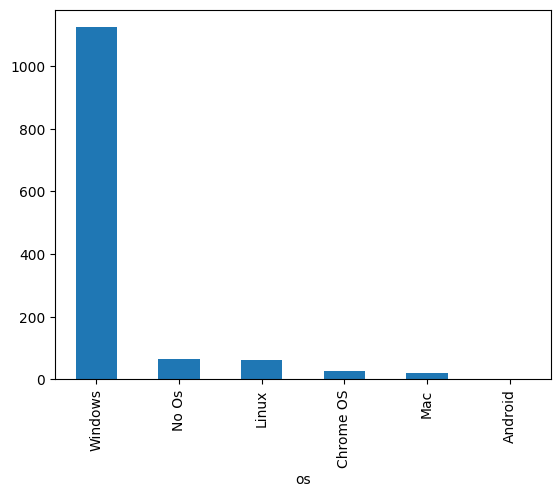

In [79]:
pc['os'].value_counts().plot(kind='bar')

[Text(0.5, 1.0, 'prix selon les types')]

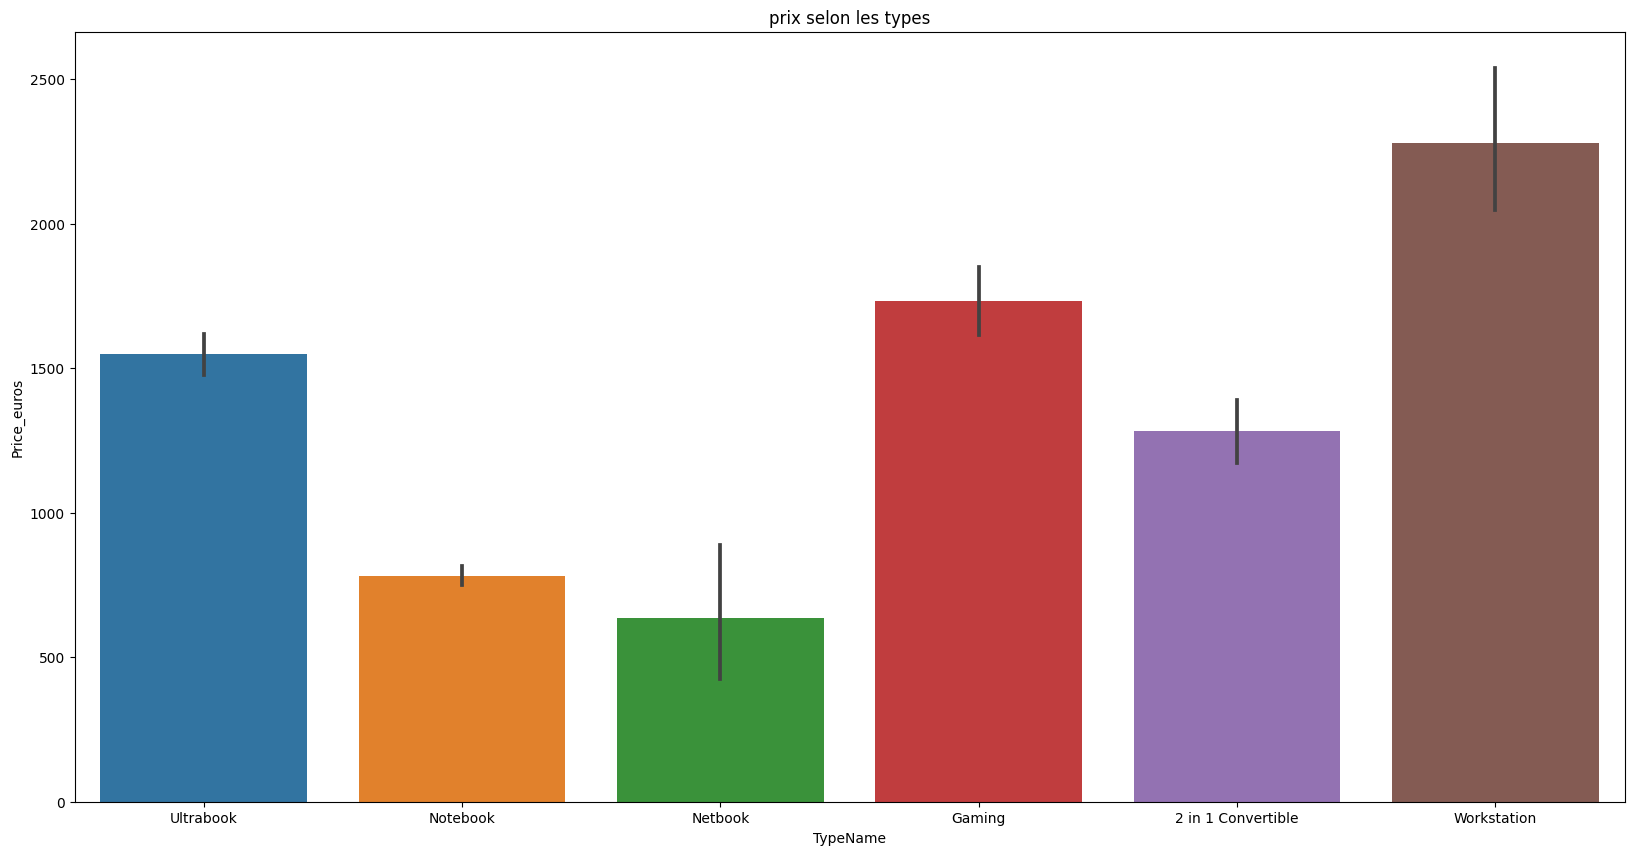

In [80]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=laptop, x='TypeName', y='Price_euros', ax=ax)
ax.set(title='prix selon les types')

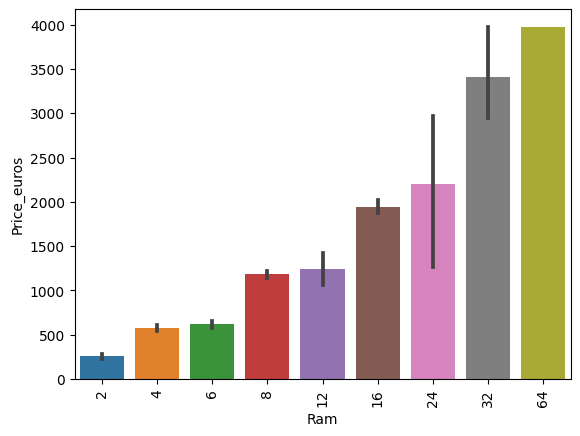

In [81]:
sns.barplot(x=pc['Ram'],y=laptop['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

<Axes: xlabel='Poids', ylabel='Price_euros'>

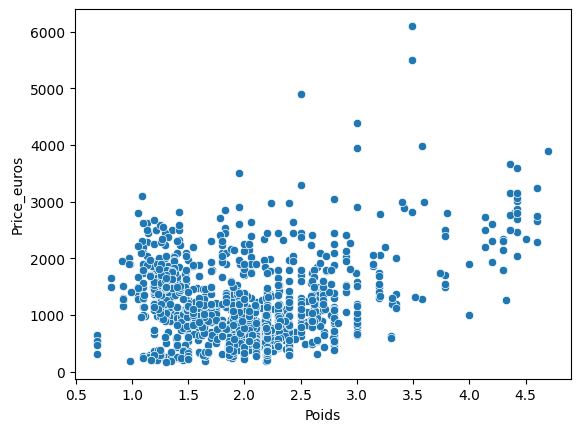

In [82]:
sns.scatterplot(x=pc['Poids'],y=pc['Price_euros'])

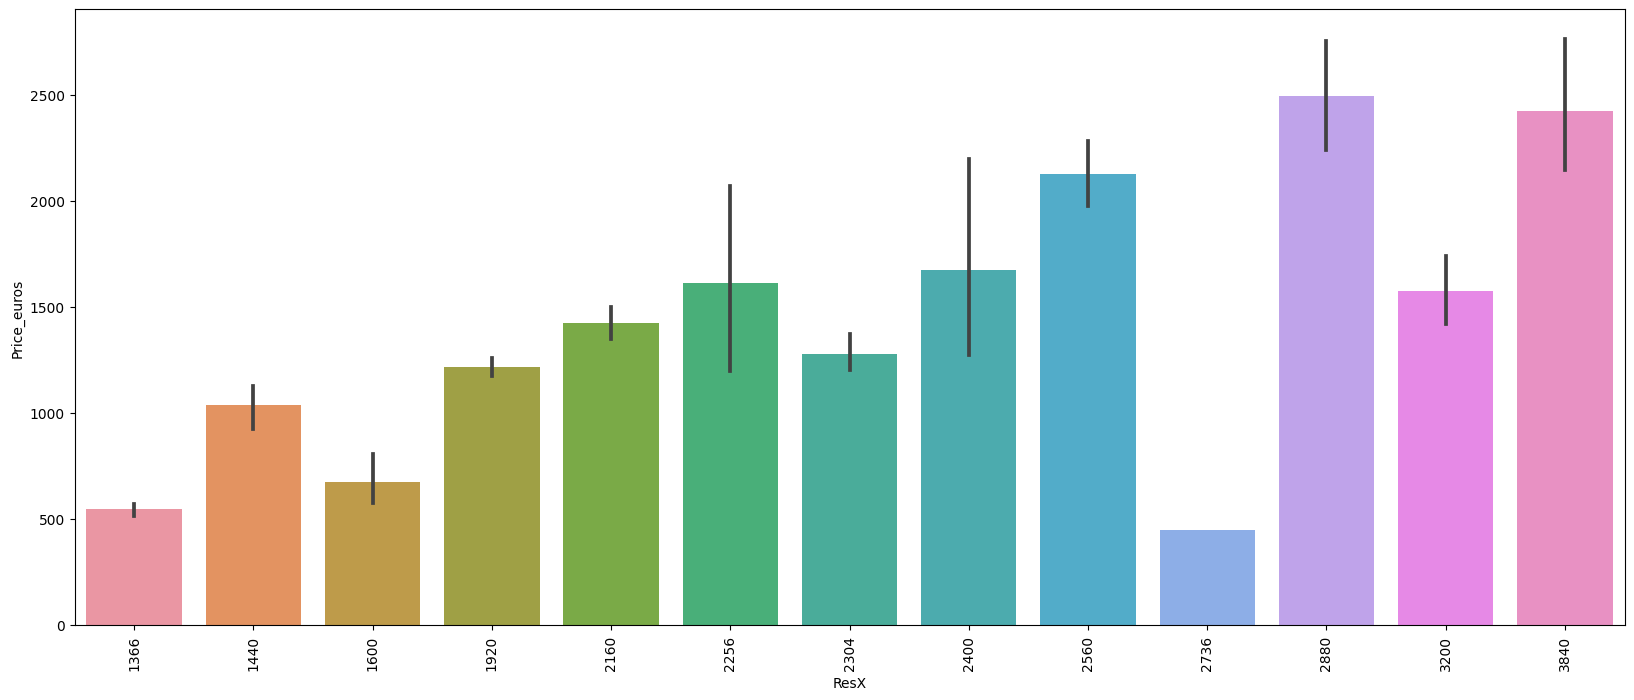

In [83]:
plt.figure(figsize=(20,8)) 

sns.barplot(x=pc['ResX'],y=pc['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

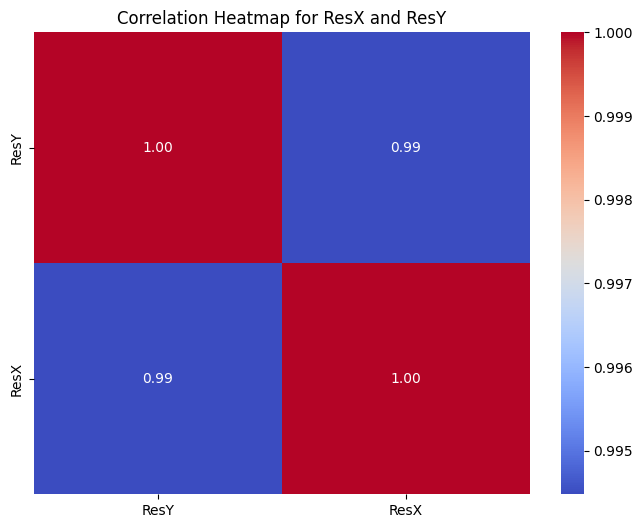

In [84]:
plt.figure(figsize=(8, 6))
correlation_matrix = pc[['ResY', 'ResX']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for ResX and ResY')
plt.show()

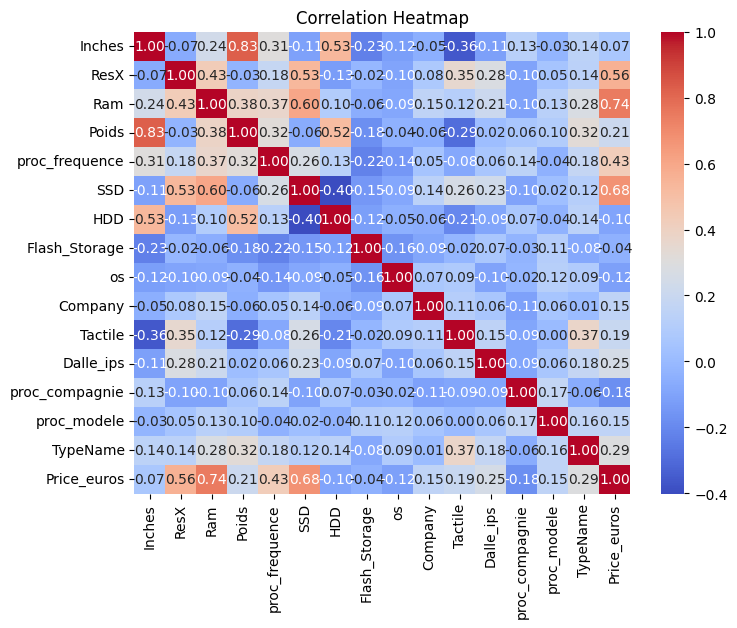

In [85]:
correlation_matrix = pc_analyse.corr() 

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

<h3 style="text-decoration: underline;">Nous remarquons:<h3>
1-une forte correlation positive entre poids et Inches ce qui veut dire que la taille de l'ecran et proportionnel(positivement) a la masse du laptop<br>
    
2-une correlation positive parfaite entre resx et resy (la resolution horizontale et verticale) raison pour laquelle elle Resy n'est pas representé dans le second graphique !

#### Passons au clustering

In [90]:
# Sélectionner les caractéristiques pour le clustering
selected_features = [ "Price_euros","Inches","Tactile","Dalle_ips","Ram","ResX"]

data = pc[selected_features]

data_normalized = (data - data.mean()) / data.std()

num_clusters = 3
n_init_value = 10

kmeans = KMeans(n_clusters=num_clusters ,n_init=20, random_state=0)

kmeans.fit(data_normalized)

pc['cluster'] = kmeans.labels_

print(pc['cluster'].value_counts())

cluster_dataframes = []
for cluster_num in range(num_clusters):
    cluster_df = pc[pc['cluster'] == cluster_num].copy()
    cluster_dataframes.append(cluster_df)

cluster_names = ["milieu_gamme","haut_gamme", "bas_gamme" ]
for idx, cluster_df in enumerate(cluster_dataframes):
    cluster_df_name = cluster_names[idx]
    globals()[cluster_df_name] = cluster_df

    

KeyError: "['Resx'] not in index"

In [87]:
print("ordinateur bas de gamme :")
display(haut_gamme.head(5))  # DataFrame du cluster 0 (bas de gamme)

print("ordinateur milieu de gamme :")
display(milieu_gamme.head(5))  # DataFrame du cluster 1 (milieu de gamme)

print("ordinateur haut de gamme :")
display(bas_gamme.head(5))  # DataFrame du cluster 2 (haut de gamme)


ordinateur bas de gamme :


,Company,TypeName,Inches,Price_euros,Produit,os,Poids,Ram,Tactile,Dalle_ips,...,gpu_modele,SSD,HDD,Flash_Storage,ResX,ResY,proc_compagnie,proc_frequence,proc_modele,cluster
19,Dell,Ultrabook,13.3,979.0,XPS 13,Windows,1.22,8,1,1,...,UHD Graphics 620,128.0,0.0,0.0,1920,1080,Intel,1.60,Core i5 8250U,1
23,Dell,2 in 1 Convertible,13.3,819.0,Inspiron 5379,Windows,1.62,8,1,0,...,UHD Graphics 620,256.0,0.0,0.0,1920,1080,Intel,1.60,Core i5 8250U,1
33,Dell,Ultrabook,13.3,1869.0,XPS 13,Windows,1.20,16,1,0,...,UHD Graphics 620,512.0,0.0,0.0,3200,1800,Intel,1.80,Core i7 8550U,1
44,Dell,2 in 1 Convertible,17.3,999.0,Inspiron 7773,Windows,2.77,12,1,0,...,GeForce 150MX,0.0,1000.0,0.0,1920,1080,Intel,1.60,Core i5 8250U,1
50,Lenovo,2 in 1 Convertible,10.1,319.0,Yoga Book,Android,0.69,4,1,1,...,HD Graphics 400,0.0,0.0,64.0,1920,1200,Intel,1.44,Atom x5-Z8550,1


ordinateur milieu de gamme :


,Company,TypeName,Inches,Price_euros,Produit,os,Poids,Ram,Tactile,Dalle_ips,...,gpu_modele,SSD,HDD,Flash_Storage,ResX,ResY,proc_compagnie,proc_frequence,proc_modele,cluster
1,Apple,Ultrabook,13.3,898.94,Macbook Air,Mac,1.34,8,0,0,...,HD Graphics 6000,0.0,0.0,128.0,1440,900,Intel,1.8,Core i5,0
2,HP,Notebook,15.6,575.00,250 G6,No Os,1.86,8,0,0,...,HD Graphics 620,256.0,0.0,0.0,1920,1080,Intel,2.5,Core i5 7200U,0
5,Acer,Notebook,15.6,400.00,Aspire 3,Windows,2.10,4,0,0,...,Radeon R5,0.0,500.0,0.0,1366,768,AMD,3.0,A9-Series 9420,0
7,Apple,Ultrabook,13.3,1158.70,Macbook Air,Mac,1.34,8,0,0,...,HD Graphics 6000,0.0,0.0,256.0,1440,900,Intel,1.8,Core i5,0
10,HP,Notebook,15.6,393.90,250 G6,No Os,1.86,4,0,0,...,HD Graphics 620,0.0,500.0,0.0,1366,768,Intel,2.5,Core i5 7200U,0


ordinateur haut de gamme :


,Company,TypeName,Inches,Price_euros,Produit,os,Poids,Ram,Tactile,Dalle_ips,...,gpu_modele,SSD,HDD,Flash_Storage,ResX,ResY,proc_compagnie,proc_frequence,proc_modele,cluster
0,Apple,Ultrabook,13.3,1339.69,MacBook Pro,Mac,1.37,8,0,1,...,Iris Plus Graphics 640,128.0,0.0,0.0,2560,1600,Intel,2.3,Core i5,2
3,Apple,Ultrabook,15.4,2537.45,MacBook Pro,Mac,1.83,16,0,1,...,Radeon Pro 455,512.0,0.0,0.0,2880,1800,Intel,2.7,Core i7,2
4,Apple,Ultrabook,13.3,1803.60,MacBook Pro,Mac,1.37,8,0,1,...,Iris Plus Graphics 650,256.0,0.0,0.0,2560,1600,Intel,3.1,Core i5,2
6,Apple,Ultrabook,15.4,2139.97,MacBook Pro,Mac,2.04,16,0,1,...,Iris Pro Graphics,0.0,0.0,256.0,2880,1800,Intel,2.2,Core i7,2
8,Asus,Ultrabook,14.0,1495.00,ZenBook UX430UN,Windows,1.30,16,0,0,...,GeForce MX150,512.0,0.0,0.0,1920,1080,Intel,1.8,Core i7 8550U,2


#### Conversion du dataframe en json pour la création d'une application web pour une interface client qui propose des ordinateurs avec le meilleur rapport qualité prix 

In [88]:
pc_json = pc.to_json(orient='records')
pc_json1 = bas_gamme.to_json(orient='records')
pc_json2 = haut_gamme.to_json(orient='records')
pc_json3 = milieu_gamme.to_json(orient='records')
print(pc_json)

with open('pc_data.json', 'w') as json_file:
     json_file.write(pc_json)
with open('pc_low.json', 'w') as json_file:
     json_file.write(pc_json1)
with open('pc_mid.json', 'w') as json_file:
     json_file.write(pc_json2)
with open('pc_high.json', 'w') as json_file:
     json_file.write(pc_json3)

[{"Company":"Apple","TypeName":"Ultrabook","Inches":13.3,"Price_euros":1339.69,"Produit":"MacBook Pro","os":"Mac","Poids":1.37,"Ram":8,"Tactile":0,"Dalle_ips":1,"gpu_compagnie":"Intel","gpu_modele":"Iris Plus Graphics 640","SSD":128.0,"HDD":0.0,"Flash_Storage":0.0,"ResX":2560,"ResY":1600,"proc_compagnie":"Intel","proc_frequence":2.3,"proc_modele":"Core i5","cluster":2},{"Company":"Apple","TypeName":"Ultrabook","Inches":13.3,"Price_euros":898.94,"Produit":"Macbook Air","os":"Mac","Poids":1.34,"Ram":8,"Tactile":0,"Dalle_ips":0,"gpu_compagnie":"Intel","gpu_modele":"HD Graphics 6000","SSD":0.0,"HDD":0.0,"Flash_Storage":128.0,"ResX":1440,"ResY":900,"proc_compagnie":"Intel","proc_frequence":1.8,"proc_modele":"Core i5","cluster":0},{"Company":"HP","TypeName":"Notebook","Inches":15.6,"Price_euros":575.0,"Produit":"250 G6","os":"No Os","Poids":1.86,"Ram":8,"Tactile":0,"Dalle_ips":0,"gpu_compagnie":"Intel","gpu_modele":"HD Graphics 620","SSD":256.0,"HDD":0.0,"Flash_Storage":0.0,"ResX":1920,"ResY

recuperation des valeurs uniques des variables enumerables;pour proposer ces options au utilisateurs de l'application,utiliser cette approche permet de rendre dynamique l'application en prevision de nouvelles valeurs uniques (par exemple si des ram de 128gb deviennent a un moment disponible il sera automatiquement disponible comme choix pour l'utilisateur dans la collone RAM de l'application).

In [89]:
# Liste des noms de colonnes énumérables
enumerable_columns = ["Company", "TypeName", "Inches","os","Ram" ,"Tactile","Dalle_ips","gpu_compagnie","SSD","HDD","Flash_Storage","ResX","ResY","proc_compagnie"]  # Ajoutez les noms des colonnes nécessaires

# Créer un dictionnaire pour stocker les valeurs uniques de chaque colonne
unique_values = {}
for column in enumerable_columns:
    unique_values[column] = pc[column].unique().tolist()
print()
# Écrire le dictionnaire dans un fichier JSON
with open('unique_values.json', 'w') as json_file:
    json.dump(unique_values, json_file)

# Merci d'avoir suivi notre exposé !